# Neural networks

In this notebook we will train a convolutional neural network on the _mnist_ dataset.

### Import packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import DotProduct

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, ReLU, CrossEntropyLoss
from torch.optim import Adam, SGD

### Load the data

In [4]:
digits = datasets.load_digits()

### Define some parameters

Save the data into loaders, which will be used during training.

In [128]:
from torch.utils.data import TensorDataset, DataLoader

def getLoaders(digits, batchsize = 16, Ntrain = 1697):
    # extract X and y
    X = digits.data
    y = np.array(digits.target, dtype = int)

    # choose size of data
    N,d = X.shape
    X = X.reshape(N, 8, 8) # change back to images
    Ntest = 100
    # Ntrain = 1697

    # choose train data
    X_train = X[0:Ntrain,:]
    y_train = y[0:Ntrain]

    # choose test data
    X_test = X[Ntrain:Ntrain+Ntest,:]
    y_test = y[Ntrain:Ntrain+Ntest]

    X_train, X_test = torch.Tensor(X_train).unsqueeze(1), torch.Tensor(X_test).unsqueeze(1)
    y_train, y_test = torch.Tensor(y_train), torch.Tensor(y_test)

    train_set = TensorDataset(X_train, y_train.long())
    test_set = TensorDataset(X_test, y_test.long())

    trainLoader = DataLoader(train_set, batch_size=batchsize)
    testLoader = DataLoader(test_set, batch_size=batchsize)

    return trainLoader, testLoader

In [153]:
# code used for checking accuracy

def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            y = y.view(-1)
            
            scores = model(x)
            _, predictions = scores.max(1)

            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
    
    model.train()

    return float(num_correct)/float(num_samples)*100

# code for checking loss

def check_loss(loader, model, criterion):
    running_loss = 0.0

    with torch.no_grad():
        for x, y in loader:
            outputs = model(x)

            running_loss += criterion(outputs, y.view(-1))

    model.train()

    return running_loss / (loader.batch_size * len(loader))


Define the mini-batch gradient descent algorithm

In [7]:
def MGD(model, train_dataloader, test_dataloader, optimizer, criterion, n_epochs, printing = True):

    model.train()

    loss_train, loss_test = [], []
    accuracy_train, accuracy_test = [], []

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        for i, (X_train_batch, Y_train_batch) in enumerate(train_dataloader, 0):

            outputs = None
            
            # forward-pass
            outputs = model(X_train_batch)

            # backwards pass + gradient step
            loss = criterion(outputs, Y_train_batch)
            
            optimizer.zero_grad() # zero the parameter gradients
            loss.backward() #retain_graph=True)
            
            optimizer.step()

            if i == 0 and epoch == 0:
                smooth_loss = loss.item()
            else:
                smooth_loss = 0.99 * smooth_loss + 0.01 * loss.item()

        if printing:
            print("Epoch", epoch + 1, "comlete")
            print("The smooth loss is", smooth_loss, "\n")

        loss_train.append(check_loss(train_dataloader, model, criterion))
        loss_test.append(check_loss(test_dataloader, model, criterion))

        accuracy_train.append(check_accuracy(train_dataloader, model))
        accuracy_test.append(check_accuracy(test_dataloader, model))

    return model, loss_train, loss_test, accuracy_train, accuracy_test
        

### Plot functions

In [21]:
def plotLoss(loss_train, loss_test):
    plt.plot(loss_train, label = "Train loss")
    plt.plot(loss_test, label = "Test loss")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss plot")
    plt.legend()
    plt.show()

def plotAccuracy(accuracy_train, accuracy_test):
    plt.plot(accuracy_train, label = "Train accuracy")
    plt.plot(accuracy_test, label = "Test accuracy")

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy plot")
    plt.legend()
    plt.show()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Define the simple NN

In [40]:
class NetSimple(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=3,              
                stride=1,                   
                padding=1,                  
            ),                              
            nn.ReLU(),    
        )

        self.fc = nn.Linear(1024, 10) #  check this

    def forward(self, x):
        x = self.conv1(x)

        x = self.fc(torch.flatten(x, 1))

        return x

# Training the network

In [41]:
trainLoader, testLoader = getLoaders(digits)

model = NetSimple()

optimizer = Adam(model.parameters(), lr = 0.005)

criterion = CrossEntropyLoss()

n_epochs = 30

trained_model, loss_train, loss_test, accuracy_train, accuracy_test = MGD(model, trainLoader, testLoader, optimizer, criterion, n_epochs, True)

Epoch 1 comlete
The smooth loss is 1.5987025920273812 

Epoch 2 comlete
The smooth loss is 0.5962449155869183 

Epoch 3 comlete
The smooth loss is 0.23234894216181387 

Epoch 4 comlete
The smooth loss is 0.1048148479636325 

Epoch 5 comlete
The smooth loss is 0.05227883358486604 

Epoch 6 comlete
The smooth loss is 0.03066889247925177 

Epoch 7 comlete
The smooth loss is 0.018238185977852095 

Epoch 8 comlete
The smooth loss is 0.013913443700380602 

Epoch 9 comlete
The smooth loss is 0.0064005666139004365 

Epoch 10 comlete
The smooth loss is 0.002660869422856945 

Epoch 11 comlete
The smooth loss is 0.0010267228210912266 

Epoch 12 comlete
The smooth loss is 0.0004394298645820878 

Epoch 13 comlete
The smooth loss is 0.0002254531807303491 

Epoch 14 comlete
The smooth loss is 0.00014243553078408067 

Epoch 15 comlete
The smooth loss is 0.00010618111606042687 

Epoch 16 comlete
The smooth loss is 8.740966213962835e-05 

Epoch 17 comlete
The smooth loss is 7.567573888811505e-05 

Epoch

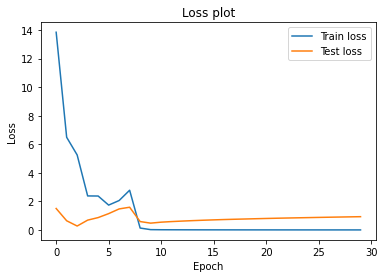

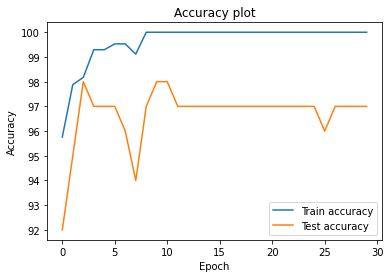

In [42]:
plotLoss(loss_train, loss_test)
plotAccuracy(accuracy_train, accuracy_test)

In [43]:
check_accuracy(testLoader, trained_model)

97.0

In [44]:
x, y = next(iter(testLoader))
y_pred = torch.argmax(trained_model(x), dim = 1)

print(y)
print(y_pred)

tensor([0, 9, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, 7, 7, 3])
tensor([0, 9, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, 7, 7, 3])


With only one convolutional layer, the model achieves 97% accuracy on the test set and 100% on the training set!

In [47]:
count_parameters(trained_model)

10410

From the above code we see that we have 10410 parameters for the simple network. Most of these come from the fully connected layer at the end. By reducing the number of in_parameters to that layers we should be able to reduce the number of trainable parameters.

# A more complicated network

In [126]:
class Net(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=64,            
                kernel_size=2,              
                stride=1,                   
                padding=1,                  
            ),                           
            nn.ReLU(),    
            nn.Dropout(0.2)
        )

        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels=64,              
                out_channels=32,            
                kernel_size=2,              
                stride=1,                   
                padding=1,                  
            ), 
            nn.MaxPool2d(2),                             
            nn.ReLU(),    
            nn.Dropout(0.2)
        )


        self.conv3 = nn.Sequential(         
            nn.Conv2d(
                in_channels=32,              
                out_channels=16,            
                kernel_size=2,              
                stride=1,                   
                padding=1, 
            ),     
            nn.ReLU(),
            nn.Dropout(0.2)                
        )

        self.conv4 = nn.Sequential(         
            nn.Conv2d(
                in_channels=16,              
                out_channels=16,            
                kernel_size=2,              
                stride=1,                   
                padding=1, 
            ),     
            nn.ReLU(),
            nn.Dropout(0.1)                
        )

        self.fc = nn.Linear(784, 10) #  check this

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = self.fc(torch.flatten(x, 1))

        return x

In [124]:
model = Net()

optimizer = Adam(model.parameters(), lr = 0.0002)

criterion = CrossEntropyLoss()

n_epochs = 100

trained_model, loss_train, loss_test, accuracy_train, accuracy_test = MGD(model, trainLoader, testLoader, optimizer, criterion, n_epochs, True)

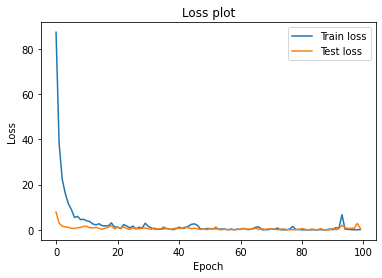

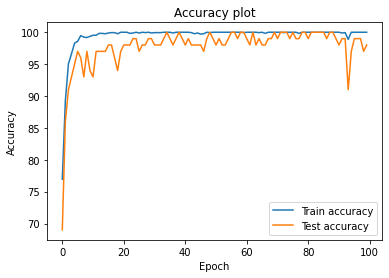

In [120]:
plotLoss(loss_train, loss_test)
plotAccuracy(accuracy_train, accuracy_test)

In [121]:
check_accuracy(testLoader, trained_model)

98.0

In [127]:
count_parameters(model)

19498

### Testing different sizes of the trainin data

In [154]:
data_sizes = [100, 200, 350, 500, 750, 1000, 1250, 1500]

accuracies_train, accuracies_test = [], []
losses_train, losses_test = [], []


for n_train in data_sizes:

    trainLoader, testLoader = getLoaders(digits, Ntrain=n_train)

    model = Net()

    optimizer = Adam(model.parameters(), lr = 0.002)

    criterion = CrossEntropyLoss()

    n_epochs = 50

    _, loss_train, loss_test, accuracy_train, accuracy_test = MGD(model, trainLoader, testLoader, optimizer, criterion, n_epochs, False)

    accuracies_train.append(accuracy_train[-1])
    accuracies_test.append(accuracy_test[-1])

    losses_train.append(loss_train[-1])
    losses_test.append(loss_test[-1])


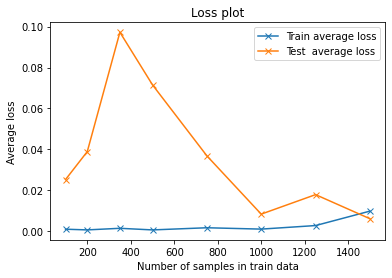

In [157]:
plt.plot(data_sizes, losses_train, '-x', label = "Train average loss")
plt.plot(data_sizes, losses_test, '-x', label = "Test  average loss")

plt.xlabel("Number of samples in train data")
plt.ylabel("Average loss")
plt.title("Loss plot")
plt.legend()
plt.show()


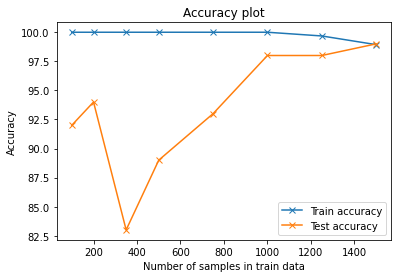

In [156]:
plt.plot(data_sizes, accuracies_train, '-x', label = "Train accuracy")
plt.plot(data_sizes, accuracies_test, '-x', label = "Test accuracy")

plt.xlabel("Number of samples in train data")
plt.ylabel("Accuracy")
plt.title("Accuracy plot")
plt.legend()
plt.show()